#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]  
# kp, kd=1.95e4,1.5e4

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
hak=1e15 # moment of area vs moment of inertia; has proportionality coefficient

In [11]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
# diag_Irho = 1e-2*np.array([0.5, 0.5, 1])  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Irho_=hak*np.diag(diag_Irho)

In [12]:
Irho_

array([[1.e+17, 0.e+00, 0.e+00],
       [0.e+00, 1.e+17, 0.e+00],
       [0.e+00, 0.e+00, 2.e+17]])

In [13]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [14]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [15]:
vessel_inertia

60751987031.24999

In [16]:
def inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws):
    V_rho=np.zeros(Irho_.shape)
    np.fill_diagonal(V_rho, vessel_inertia)
    cum_m=0
    cum_i=0
    fin_123=[]
    for i in range(node_N-1,-1,-1):
        cum_m+=Ws[i]*cum_d_inv[i]**2
        cum_i+=Irho_
        fin_123.append(V_rho+cum_m + cum_i)
    return np.array(fin_123[::-1])

In [17]:
lll = [100 for i in range(node_N)]

In [18]:
cum_d_inv=[10]
sum_=0
for i in range(len(lll)-1,-1,-1):
    sum_+=lll[i]
    cum_d_inv.append(sum_)
cum_d_inv=cum_d_inv[::-1]    

In [19]:
cum_d_inv

[5000,
 4900,
 4800,
 4700,
 4600,
 4500,
 4400,
 4300,
 4200,
 4100,
 4000,
 3900,
 3800,
 3700,
 3600,
 3500,
 3400,
 3300,
 3200,
 3100,
 3000,
 2900,
 2800,
 2700,
 2600,
 2500,
 2400,
 2300,
 2200,
 2100,
 2000,
 1900,
 1800,
 1700,
 1600,
 1500,
 1400,
 1300,
 1200,
 1100,
 1000,
 900,
 800,
 700,
 600,
 500,
 400,
 300,
 200,
 100,
 10]

In [20]:
Ws = np.array(mi)*9.81

In [21]:
Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
# Irho=np.array(fin_123)

In [22]:
# Irho+=vessel_inertia

In [23]:
Irho[-1][0][0]

1.0000006076140462e+17

In [24]:
Irho[-49][0][0]

4.900000441458467e+18

In [25]:
Irho

array([[[5.00000047e+18, 4.04250480e+11, 4.04250480e+11],
        [4.04250480e+11, 5.00000047e+18, 4.04250480e+11],
        [4.04250480e+11, 4.04250480e+11, 1.00000005e+19]],

       [[4.90000044e+18, 3.80706480e+11, 3.80706480e+11],
        [3.80706480e+11, 4.90000044e+18, 3.80706480e+11],
        [3.80706480e+11, 3.80706480e+11, 9.80000044e+18]],

       [[4.80000042e+18, 3.58094822e+11, 3.58094822e+11],
        [3.58094822e+11, 4.80000042e+18, 3.58094822e+11],
        [3.58094822e+11, 3.58094822e+11, 9.60000042e+18]],

       [[4.70000040e+18, 3.36396672e+11, 3.36396672e+11],
        [3.36396672e+11, 4.70000040e+18, 3.36396672e+11],
        [3.36396672e+11, 3.36396672e+11, 9.40000040e+18]],

       [[4.60000038e+18, 3.15593194e+11, 3.15593194e+11],
        [3.15593194e+11, 4.60000038e+18, 3.15593194e+11],
        [3.15593194e+11, 3.15593194e+11, 9.20000038e+18]],

       [[4.50000036e+18, 2.95665552e+11, 2.95665552e+11],
        [2.95665552e+11, 4.50000036e+18, 2.95665552e+11],
    

In [26]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [27]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [28]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [29]:
E = 210e9

In [30]:
E*Ar/1e10

1.6991625880187402

In [31]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [32]:
DT=np.diag(diag_DT) # (35) in [2]

In [33]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [34]:
# diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]
diag_CT = 1e10*np.array([1.7, 1.7, 1.7]) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [35]:
CT=np.diag(diag_CT)

In [36]:
CT

array([[1.7e+10, 0.0e+00, 0.0e+00],
       [0.0e+00, 1.7e+10, 0.0e+00],
       [0.0e+00, 0.0e+00, 1.7e+10]])

In [37]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [38]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [39]:
rng = np.random.default_rng()

In [40]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [41]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [42]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.98687719, -0.01961777, -0.16027648],
       [ 0.15033456,  0.47388757,  0.86765782],
       [ 0.05893152, -0.88036681,  0.47061806]])

In [43]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.009569


In [44]:
Ret.shape

(50, 3, 3)

In [45]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [46]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))  
#     print(Ret[0].shape, B.T[0].shape)
#     print(np.linalg.solve(Ret[0],B.T[0].astype(np.float64)).shape)
#     ans=[]
#     for i in range(len(B.T)):
#         ans.append(np.dot(Ret[i],np.linalg.solve(Ret[i],B.T[i].astype(np.float64))))
#         print(ans[-1])
#     ans=np.tensordot(Ret, np.linalg.solve(Ret,B.T.astype(np.float64)),axes = 0)
    return np.array(ans).T

In [47]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000302


In [48]:
C1(dx,dy,dz,Ret)

array([[ 2.32936848e+00,  4.97297867e+00,  2.12280933e-02,
        -1.83415827e-01,  2.77027535e+00,  1.53966675e-01,
        -1.66572531e+00, -2.99678872e-01,  4.03731620e+00,
         1.39141964e-02, -9.60543809e-06,  8.11527815e-01,
         1.76860918e-01, -6.56499258e-03,  5.87166641e-01,
         8.20814619e-01, -3.74635189e-01,  1.80060950e-02,
         3.39510745e-01, -6.75012699e-03, -1.08295830e-02,
        -3.49296682e-01,  3.06248439e-01,  1.24767521e+00,
        -2.55408258e-01, -9.32514795e-01, -7.11104644e-02,
         1.85874046e-01, -3.35103572e-01,  2.31860291e-01,
        -4.86814832e-02, -3.88411484e+00, -1.69860396e+00,
         1.55301670e-01, -1.19923875e+00, -1.94822558e-04,
        -1.03754973e+00,  1.95490447e-01,  3.45398184e-01,
        -2.29985327e+00,  2.05346673e-01, -9.32693051e-01,
         8.49690054e-05, -3.34460626e+00,  7.36455909e-01,
        -6.11972460e+00, -4.28377908e-02,  2.08829649e-01,
         1.07477722e-03,  4.74440811e-01],
       [ 1.11

In [49]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [50]:
fD(dx,dy,dz,DT,Ret).T

array([[ 1.33683247e+04,  6.41179646e+03,  2.04583875e+03],
       [ 2.85400934e+04,  3.37525724e+03, -7.00560276e+03],
       [ 1.21828748e+02,  4.17621177e+02, -8.87901770e+01],
       [-1.05262966e+03,  7.90616344e+02, -2.44923167e+03],
       [ 1.58987043e+04,  7.14284743e+02,  9.83948208e+02],
       [ 8.83619973e+02,  2.31355860e+02, -7.01063402e+01],
       [-9.55965410e+03, -7.39943461e+03, -5.09046825e+02],
       [-1.71986722e+03,  3.18668859e+04,  4.86838910e+03],
       [ 2.31702947e+04,  1.73509773e+04, -1.62189782e+04],
       [ 7.98540456e+01,  4.05265288e+03, -1.51058623e+04],
       [-5.51259352e-02,  5.87591750e+03,  2.23444579e+03],
       [ 4.65738567e+03, -1.92680530e+03,  2.41546953e+03],
       [ 1.01501081e+03, -3.08716897e+03, -2.51914748e+04],
       [-3.76767152e+01,  1.59108320e+04, -9.45897538e+03],
       [ 3.36976928e+03, -7.68402794e+02, -1.75657887e+03],
       [ 4.71068295e+03,  8.35241125e+03,  1.98177468e+03],
       [-2.15004406e+03, -1.31154559e+03

In [51]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000304


In [52]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [53]:
I=np.identity(3)

In [54]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.001680


In [55]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [56]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [57]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [58]:
DR=np.diag(diag_DR) 

In [59]:
Ar

0.08091250419136858

In [60]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [61]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [62]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [63]:
def Re_b(Ret):
    return Ret

In [64]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000081


In [65]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))
#     return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float64))

In [66]:
phi(x,y,z,Ret,None,None)

array([[-1.34998147,  1.50352141, -0.21827307],
       [-0.8995176 , -0.18484768, -0.53160013],
       [ 0.67260264, -0.4485501 ,  0.37766009],
       [-1.32668324,  0.97194183,  0.33048449],
       [-1.17928096, -1.61759125, -1.77160093],
       [-0.92109516, -0.88849115,  2.4448253 ],
       [-0.53352736,  0.39041726, -0.94863194],
       [-0.47998152,  1.17698055, -1.14957049],
       [ 2.15904687,  0.82278371, -0.4866185 ],
       [-0.05489266, -0.45910744, -1.41719508],
       [ 1.41281878,  1.58765135,  1.06983554],
       [ 2.48352499, -2.46050688,  0.52112576],
       [-0.04937304, -0.30599851,  0.3413376 ],
       [ 0.00534921, -2.26509561, -1.07122124],
       [-0.78110165,  0.19979121,  0.36901054],
       [-0.91532027,  0.15403902, -1.04040907],
       [ 1.19480755,  1.24426445,  1.60897219],
       [ 0.24165833, -0.46459608,  0.82970741],
       [ 1.1113197 ,  1.1059352 ,  0.51426894],
       [ 1.16160582,  0.73330788, -1.23419918],
       [-0.04918363, -0.7765647 , -1.370

In [67]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000372


In [68]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [69]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [70]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.005458


In [71]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [72]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.004229


In [73]:
ωe(φ,θ,ψ,None,None,None)

array([[-1.31993135e-01,  1.37473203e+00, -2.22902987e+00],
       [-1.04362235e+00, -6.17060924e-02, -1.94082871e-01],
       [-1.34617202e+00,  8.96572008e-01, -6.26887900e-01],
       [-1.56993127e+00,  1.86394571e+00, -6.63364321e-01],
       [-6.08925059e-01,  3.33431197e-01,  1.68322415e-01],
       [ 5.20775389e-01, -7.56701548e-01,  4.59760139e-01],
       [-1.26420947e+00, -3.84263624e+00,  5.36987299e-01],
       [-7.30900215e-01,  3.63624370e-02, -3.58929838e-01],
       [ 6.25844772e-01,  6.55444374e-01, -1.59013161e+00],
       [-2.14177248e+00, -1.19817982e+00, -3.67092103e-01],
       [-2.42994960e-01,  1.84555606e+00, -8.68278398e-01],
       [ 1.63207971e-01,  8.32001210e-01,  2.85228872e-01],
       [ 1.42022192e-01, -3.73216258e-01,  8.34656250e-01],
       [-1.33440972e+00,  4.56528255e-01,  3.25725169e-02],
       [-7.66434329e-01, -4.89848130e-01, -3.44227596e-01],
       [-6.84970898e-01, -7.72641275e-02, -1.09344876e-01],
       [ 1.44376676e+00,  8.35724422e-01

In [74]:
def d_s(f,a,b,c,Ret,omega): # here
    
    fun = f(a,b,c,Ret,omega, None) 
    
#     if flag==1:
#         fun+=-np.dot(Ret,force)
# #         fun*=-np.dot(Ret,force)
#     elif flag==2:
#         fun+=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#         fun*=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#     print(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)))
#     print(np.dot(np.linalg.inv(Π(φ,θ,ψ).astype(np.float64))[2],Re_b(Ret)[2]))
        
# #     print(fun)
#     if any(force):
# #         fun[-1]=-np.array(force)
#         fun[-1]=-np.dot(Ret[-1],force)
# #         fun+=-np.dot(Ret,force) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# #     print(fun)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun).T

In [75]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [76]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[-1.54206775e-02, -3.13098114e-03,  7.41389631e-03,
        -5.72354161e-03, -1.47062824e-03,  2.99591060e-02,
        -1.20333307e-02, -2.08815084e-02, -1.17439300e-02,
        -8.64830653e-03, -4.57848029e-03,  2.67114560e-02,
         5.81115930e-03,  1.06288353e-02,  1.53366593e-03,
        -1.07439963e-02,  3.34780967e-03,  1.16266797e-02,
        -5.26835712e-03, -1.76726321e-02, -5.38773031e-03,
        -6.84032584e-03, -2.97778141e-03, -1.32282698e-02,
         1.18349576e-02,  1.85934826e-03,  4.02363888e-03,
        -2.80690182e-03, -1.91087241e-02, -1.03410375e-03,
        -1.56384053e-02,  2.41711843e-02,  1.31187139e-02,
        -1.92234504e-03, -4.46039149e-03,  5.23674342e-03,
        -1.26856544e-03,  2.43178661e-02,  5.60716679e-03,
        -1.84011175e-05, -2.38341304e-02, -3.01329462e-03,
         6.05484673e-03,  1.02762720e-02, -2.83057922e-02,
        -1.91741897e-02,  1.20513452e-02,  2.88154486e-03,
         3.47077260e-03, -5.47283309e-03],
       [ 9.76

In [77]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.004529


In [78]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [79]:
# np.dot(Ret.astype(np.float64)[2],np.array([1,0,0]).reshape(3,1)).squeeze()

In [80]:
# np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()

In [81]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [82]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[-1.38638252e-07,  2.01856805e-07,  1.32255028e-06,
        -2.85257047e-06,  1.14967885e-06,  6.13580720e-07,
        -7.04788725e-07, -1.35621706e-06, -8.70254488e-07,
         2.13212891e-07, -2.37530489e-06,  3.36767601e-06,
         6.81893988e-07,  4.05845688e-06, -1.39121390e-08,
         2.64497231e-07,  2.25934194e-06,  1.14125068e-06,
        -2.42672417e-07, -6.68061334e-07,  3.45384790e-07,
         6.44674639e-07, -8.54181250e-07, -1.60232821e-06,
         5.15798825e-07,  4.35710556e-07,  2.03313164e-06,
         1.15210048e-06,  2.17284418e-06,  2.34045578e-07,
        -1.15714463e-06,  8.04945442e-07,  1.89341471e-07,
         1.69283996e-06, -2.28892544e-07, -5.27610643e-08,
        -1.09537933e-06,  1.87327757e-06, -2.31079799e-06,
         6.43166945e-08, -1.20454168e-06, -2.26715957e-07,
         5.61265867e-07, -2.24315872e-06,  1.36125828e-07,
         1.07752997e-07,  3.18959490e-07,  2.48744944e-08,
         8.26898859e-07, -4.50660775e-08],
       [-5.16

In [83]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [84]:
ne_(dx,dy,dz,DT,Ret)

array([[-1.33683247e+04, -2.85400934e+04, -1.21828748e+02,
         1.05262966e+03, -1.58987043e+04, -8.83619973e+02,
         9.55965410e+03,  1.71986722e+03, -2.31702947e+04,
        -7.98540456e+01,  5.51259352e-02, -4.65738567e+03,
        -1.01501081e+03,  3.76767152e+01, -3.36976928e+03,
        -4.71068295e+03,  2.15004406e+03, -1.03337590e+02,
        -1.94846369e+03,  3.87392079e+01,  6.21513442e+01,
         2.00462551e+03, -1.75757018e+03, -7.16045036e+03,
         1.46579666e+03,  5.35173406e+03,  4.08105368e+02,
        -1.06673746e+03,  1.92317077e+03, -1.33065408e+03,
         2.79384684e+02,  2.22910669e+04,  9.74834575e+03,
        -8.91281557e+02,  6.88247191e+03,  1.11809327e+00,
         5.95453309e+03, -1.12192631e+03, -1.98225190e+03,
         1.31989360e+04, -1.17849153e+03,  5.35275707e+03,
        -4.87640005e-01,  1.91948088e+04, -4.22654545e+03,
         3.51213072e+04,  2.45847535e+02, -1.19848044e+03,
        -6.16818293e+00, -2.72283192e+03],
       [-6.41

In [85]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.004077


In [86]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[-3.43531017e+03, -1.10968925e+07,  4.57993101e+07],
       [ 3.21517781e+02,  2.27226937e+06, -5.52020291e+06],
       [-5.78410936e+01, -4.97064744e+05,  1.08137291e+06],
       [-5.66087378e+02,  8.05311147e+05,  4.91299117e+06],
       [ 1.93119423e+03, -2.96422216e+07,  1.01357260e+07],
       [-3.64518191e+03,  3.37865373e+07,  3.03362960e+06],
       [ 6.97772023e+02, -6.28531644e+06, -7.62923292e+05],
       [-4.11090761e+03,  1.17028802e+05,  4.14093818e+07],
       [ 1.43722025e+01, -3.24610724e+05,  1.79446078e+05],
       [-2.71825211e+03,  3.39556467e+07, -6.49888860e+06],
       [ 4.07640393e+02, -4.21148192e+06,  9.39076416e+04],
       [ 1.02191466e+04, -5.52123149e+07, -4.80138035e+07],
       [ 5.08470303e+02,  4.61626636e+07, -5.13013260e+07],
       [ 4.83390652e+02, -4.07875450e+06, -8.04019275e+05],
       [ 2.57921633e+02,  1.84739207e+07, -2.10802575e+07],
       [-2.11749167e+03,  7.72268859e+06,  1.36668051e+07],
       [ 3.55353742e+03, -5.77625671e+07

In [87]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[ 9.28421691e+09,  4.58085015e+09,  1.11060834e+09],
       [-1.63394867e+10, -5.53637900e+08, -2.28844465e+08],
       [-4.20225735e+07,  1.08133131e+08,  4.97023144e+07],
       [ 5.72176388e+08,  4.91355763e+08, -8.04744721e+07],
       [-1.42271561e+10,  1.01216411e+09,  2.96281374e+09],
       [-6.50644219e+09,  3.02718822e+08, -3.37929783e+09],
       [ 3.36266362e+09, -7.59594254e+07,  6.28864531e+08],
       [-9.56734446e+09,  4.13999101e+09, -1.26499994e+07],
       [-8.42985135e+09,  1.71100524e+07,  3.16265593e+07],
       [-3.69207380e+08, -6.49925411e+08, -3.39560122e+09],
       [ 3.39453533e+08,  9.42437006e+06,  4.21181796e+08],
       [-4.44509391e+09, -4.80182041e+09,  5.52079145e+09],
       [-4.35406480e+09, -5.13056365e+09, -4.61669739e+09],
       [-1.19562627e+10, -8.15855977e+07,  4.06691840e+08],
       [-1.03427235e+10, -2.10904968e+09, -1.84841595e+09],
       [-1.64437335e+10,  1.36505258e+09, -7.73896706e+08],
       [ 2.57907509e+08,  2.18696192e+09

In [88]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000318


In [89]:
Re_b(Ret).shape

(50, 3, 3)

In [90]:
# def Irho_e(Ret):
    
#     ans1 = np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    
#     sum_=np.zeros(Irho.shape)
# #     print(sum_)
    
#     for i in range(len(ans1)):
#         sum_+=ans1[i]
#         ans1[i]=sum_
        
#     tmp=np.zeros(Irho.shape)
#     np.fill_diagonal(tmp, vessel_inertia)
    
#     ans2=np.multiply(np.multiply(Ret,tmp),Ret)
#     ans1[-1]+=ans2[-1]
    
#     for i in range(int(node_N/4)):
#         ans1[i]*=(10-i+1)
#     return ans1
def Irho_e(Ret,Irho): # here
#     ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
#     print(Irho[1])
#     print(np.dot(np.dot(Ret[1],Irho[1]),Ret[1]))
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [91]:
Irho_e(Ret,Irho)

array([[[ 1.66761167e+18, -5.14485285e+18, -1.07886467e+17],
        [ 4.62437005e+18,  3.13062867e+18, -3.01547693e+18],
        [ 1.11237667e+18, -2.80488076e+18,  8.44715729e+18]],

       [[ 4.66522522e+18,  1.24238134e+18, -1.59765795e+18],
        [ 1.57715499e+18, -6.39986135e+18,  5.89836610e+18],
        [-9.17424288e+16, -6.11022172e+18, -1.61866506e+18]],

       [[-2.33059027e+18, -6.78321267e+18,  4.85748906e+18],
        [-1.04257857e+18, -3.17066524e+18, -3.56900649e+18],
        [ 4.06707705e+18, -4.44880677e+18,  1.72924787e+18]],

       [[ 7.69187924e+17, -8.88853745e+18,  2.13679038e+17],
        [ 1.88284573e+18,  2.10073000e+18, -4.45785337e+18],
        [ 4.33955256e+18, -1.04230370e+18,  2.26889037e+18]],

       [[ 3.21398736e+18, -2.71406588e+18,  3.06475734e+18],
        [-2.35667695e+18, -7.39858944e+16,  6.12190451e+18],
        [-3.46917544e+18, -5.90214049e+18,  3.15655703e+18]],

       [[-9.40314139e+17, -5.20395588e+18, -3.29809224e+18],
        [-4.30

In [92]:
startTime1 = datetime.now()
Irho_e(Ret,Irho)
print(datetime.now() - startTime1)

0:00:00.000206


In [93]:
79.3*1e9*math.pi*(d0**4-dI**4)/64

423167467.8322429

In [94]:
# diag_CR = 1e11*np.array([1, 1, 1])
diag_CR = 1e9*np.array([4, 4, 4]) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

CR=np.diag(diag_CR)

In [95]:
CR

array([[4.e+09, 0.e+00, 0.e+00],
       [0.e+00, 4.e+09, 0.e+00],
       [0.e+00, 0.e+00, 4.e+09]])

In [96]:
def d_me(φ,θ,ψ,Ret,omega):
    
    def f(a,b,c,Ret,omega, dummy2): 
        return np.einsum('ijk,ik->ik', np.multiply(np.multiply(Ret,CR),Ret),omega.astype(np.float64)).squeeze()
   
    B=d_s(f,φ,θ,ψ,Ret.astype(np.float64),omega.astype(np.float64))

    return B.T.astype(np.float64)

In [97]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.002862


In [98]:
d_me_

array([[ 1.05712843e-03, -2.82413222e+00, -7.85432894e+00],
       [-1.21058500e-05,  2.97953265e+01, -2.96745489e+01],
       [ 8.98255058e-04, -8.60456841e+00, -4.68737233e-01],
       [ 5.50036648e-05,  2.34966672e+00, -2.90540643e+00],
       [-3.44713280e-04,  1.29125439e+01, -9.43107008e+00],
       [-1.18807823e-03,  9.53763277e+00,  2.46328021e+00],
       [ 1.57001851e-04,  1.13955224e+01, -1.29820572e+01],
       [ 8.07228138e-04,  2.08392129e+00, -1.02382583e+01],
       [-4.39099958e-05,  2.46880900e+01, -2.42457834e+01],
       [ 5.31836627e-04, -6.02519174e+00,  6.53138597e-01],
       [-1.40895989e-03,  1.91165905e+00,  1.23208810e+01],
       [-1.63440411e-03, -2.75188517e+00,  1.92619909e+01],
       [ 1.91132210e-03, -2.00045160e+01,  6.98270768e-01],
       [ 5.98099395e-05,  2.90463652e+01, -2.96520085e+01],
       [-6.57776122e-04,  1.86346635e+01, -1.19910690e+01],
       [ 6.11002367e-05,  1.48778298e+01, -1.54957890e+01],
       [ 9.81787899e-04, -1.56945965e+01

In [99]:
# diag_DR = 1.5*np.array([1, 1, 1]) 
 
# DR=np.diag(diag_DR)

In [100]:
ne_(dx,dy,dz,DT,Ret)

array([[-1.33683247e+04, -2.85400934e+04, -1.21828748e+02,
         1.05262966e+03, -1.58987043e+04, -8.83619973e+02,
         9.55965410e+03,  1.71986722e+03, -2.31702947e+04,
        -7.98540456e+01,  5.51259352e-02, -4.65738567e+03,
        -1.01501081e+03,  3.76767152e+01, -3.36976928e+03,
        -4.71068295e+03,  2.15004406e+03, -1.03337590e+02,
        -1.94846369e+03,  3.87392079e+01,  6.21513442e+01,
         2.00462551e+03, -1.75757018e+03, -7.16045036e+03,
         1.46579666e+03,  5.35173406e+03,  4.08105368e+02,
        -1.06673746e+03,  1.92317077e+03, -1.33065408e+03,
         2.79384684e+02,  2.22910669e+04,  9.74834575e+03,
        -8.91281557e+02,  6.88247191e+03,  1.11809327e+00,
         5.95453309e+03, -1.12192631e+03, -1.98225190e+03,
         1.31989360e+04, -1.17849153e+03,  5.35275707e+03,
        -4.87640005e-01,  1.91948088e+04, -4.22654545e+03,
         3.51213072e+04,  2.45847535e+02, -1.19848044e+03,
        -6.16818293e+00, -2.72283192e+03],
       [-6.41

### Static solution

In [101]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [102]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [103]:
Fx_0=82945396

In [104]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [105]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [106]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [107]:
delta_x=horizontal_length/(node_N-1)

In [108]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [109]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [110]:
M_totl

array([3196782.14893616, 3195840.38893616, 3194898.62893616,
       3193956.86893616, 3193015.10893616, 3192073.34893616,
       3191131.58893616, 3190189.82893616, 3189248.06893616,
       3188306.30893616, 3187364.54893616, 3186422.78893616,
       3185481.02893616, 3184539.26893616, 3183597.50893616,
       3182655.74893616, 3181713.98893616, 3180772.22893616,
       3179830.46893616, 3178888.70893616, 3177946.94893616,
       3177005.18893616, 3176063.42893616, 3175121.66893616,
       3174179.90893616, 3173238.14893617, 3172296.38893617,
       3171354.62893617, 3170412.86893617, 3169471.10893617,
       3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617,

In [111]:
x0,z0

([0.0,
  225.56499682574736,
  451.1299936514947,
  676.6949904772421,
  902.2599873029894,
  1127.8249841287368,
  1353.3899809544841,
  1578.9549777802315,
  1804.5199746059789,
  2030.0849714317262,
  2255.6499682574736,
  2481.2149650832207,
  2706.7799619089683,
  2932.344958734716,
  3157.909955560463,
  3383.47495238621,
  3609.0399492119577,
  3834.6049460377053,
  4060.1699428634524,
  4285.7349396892,
  4511.299936514947,
  4736.864933340695,
  4962.429930166441,
  5187.994926992189,
  5413.559923817937,
  5639.124920643684,
  5864.689917469432,
  6090.254914295178,
  6315.819911120926,
  6541.384907946674,
  6766.94990477242,
  6992.514901598168,
  7218.079898423915,
  7443.644895249663,
  7669.209892075411,
  7894.774888901157,
  8120.339885726905,
  8345.904882552652,
  8571.4698793784,
  8797.034876204147,
  9022.599873029894,
  9248.164869855642,
  9473.72986668139,
  9699.294863507137,
  9924.859860332883,
  10150.42485715863,
  10375.989853984378,
  10601.554850810126,

In [112]:
length_p

[225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 

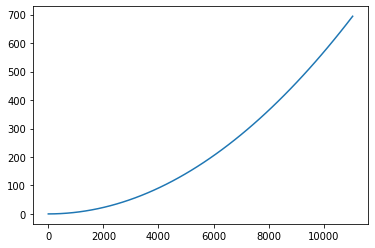

In [113]:
plt.plot(x0, z0)
plt.show()

In [114]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [115]:
init=1
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0
    elif j==7:    
        q0[(j-1)*node_N:j*node_N]=np.array([-0.00010522890316932987*(i+1)/node_N*init for i in range(node_N)])
#         q0[(j-1)*node_N]=0
    elif j==9:    
        q0[(j-1)*node_N:j*node_N]=np.array([6.952842745988619e-09*(i+1)/node_N*init for i in range(node_N)])
#         q0[(j-1)*node_N]=0
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=np.array([0.00010649100253301569*(i+1)/node_N*init for i in range(node_N)])
#        q0[(j-1)*node_N]=0 
# q0[7*node_N-1]= -0.00010522890316932987 # here
# q0[9*node_N-1]= 6.952842745988619e-09
# q0[11*node_N-1]=0.00010649100253301569 # here

In [141]:
def static_func(Q): # here
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
    Z0=-np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T
#     test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

#     Z1 = d_s(ne, x, y, z, Ret, test).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
#     print(Z.shape)
#     print()
    
    
############################################################ 
#     print(np.einsum('i,ijk->ijk',M_totl,Re_b(Ret)).shape)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_totl,Re_b(Ret)),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################ 

    sum_0123=0
    lll=[]
    for i in range(1,len(z0)):
        sum_0123=math.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
        lll.append(sum_0123)
        
    cum_d_inv=[0]
    sum_=0
    for i in range(len(lll)-1,-1,-1):
        sum_+=lll[i]
        cum_d_inv.append(sum_)
    cum_d_inv=cum_d_inv[::-1] 
     
    
    Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
    
    
    C0=-np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe(φ,θ,ψ,None,None,None))
  
    B_ =C3
    B=(B_ + C0.squeeze())

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)

    print(A2.shape)
#############################################
#     ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [142]:
q0

array([ 0.00000000e+00,  2.25564997e+02,  4.51129994e+02,  6.76694990e+02,
        9.02259987e+02,  1.12782498e+03,  1.35338998e+03,  1.57895498e+03,
        1.80451997e+03,  2.03008497e+03,  2.25564997e+03,  2.48121497e+03,
        2.70677996e+03,  2.93234496e+03,  3.15790996e+03,  3.38347495e+03,
        3.60903995e+03,  3.83460495e+03,  4.06016994e+03,  4.28573494e+03,
        4.51129994e+03,  4.73686493e+03,  4.96242993e+03,  5.18799493e+03,
        5.41355992e+03,  5.63912492e+03,  5.86468992e+03,  6.09025491e+03,
        6.31581991e+03,  6.54138491e+03,  6.76694990e+03,  6.99251490e+03,
        7.21807990e+03,  7.44364490e+03,  7.66920989e+03,  7.89477489e+03,
        8.12033989e+03,  8.34590488e+03,  8.57146988e+03,  8.79703488e+03,
        9.02259987e+03,  9.24816487e+03,  9.47372987e+03,  9.69929486e+03,
        9.92485986e+03,  1.01504249e+04,  1.03759899e+04,  1.06015549e+04,
        1.08271198e+04,  1.10526848e+04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [143]:
root = fsolve(static_func, q0)

(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)
(50, 3, 3)

KeyboardInterrupt: 

In [ ]:
root

In [ ]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [ ]:
q0=root

In [ ]:
q0

In [ ]:
# x0_

In [ ]:
# z0

In [ ]:
# z0_

In [ ]:
plt.plot(x0_, z0_)
plt.show()

In [ ]:
# init=1
# for j in range(1,12):
#     if j==1:  
#         q0[(j-1)*node_N:j*node_N]=x0_
#     elif j==5:    
#         q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
# #         q0[(j-1)*node_N]=0
#     elif j==7:    
#         q0[(j-1)*node_N:j*node_N]=np.array([-0.00010522890316932987*(i+1)/node_N*init for i in range(node_N)])
# #         q0[(j-1)*node_N]=0
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=np.array([6.952842745988619e-09*(i+1)/node_N*init for i in range(node_N)])
# #         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=np.array([0.00010649100253301569*(i+1)/node_N*init for i in range(node_N)])
#         q0[(j-1)*node_N]=0 
# # q0[9*node_N-1]=0.13  # here
# q0[7*node_N-1]= -0.00010522890316932987 # here
# q0[9*node_N-1]= 6.952842745988619e-09
# q0[11*node_N-1]=0.00010649100253301569  # here

### Vessle Simulation

In [ ]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [ ]:
vehicle=semisub('DPcontrol',0,5,40.0,0,0) 

In [ ]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [ ]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

In [ ]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [ ]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

In [ ]:
plotVehicleStates(simTime, simData, 3)

In [ ]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [ ]:
def myDPcontrol(self, eta, nu, sampleTime):
        """
        u = DPcontrol(eta,nu,sampleTime) is a nonlinear PID controller
        for DP based on pole placement:

        tau = -R' Kp (eta-r) - R' Kd R nu - R' Ki int(eta-r)
        u = B_pseudoinverse * tau
        """
        # 3-DOF state vectors
        eta3 = np.array([eta[0], eta[1], eta[5]])
        nu3 = np.array([nu[0], nu[1], nu[5]])

        # 3-DOF diagonal model matrices
        M3 = np.diag([self.M[0][0], self.M[1][1], self.M[5][5]])
        D3 = np.diag([self.D[0][0], self.D[1][1], self.D[5][5]])

        [tau3, self.e_int, self.x_d, self.y_d, self.psi_d] = DPpolePlacement(
            self.e_int,
            M3,
            D3,
            eta3,
            nu3,
            self.x_d,
            self.y_d,
            self.psi_d,
            self.wn,
            self.zeta,
            self.ref,
            sampleTime,
        )
        
        tau=list(tau3)+[tau3[2]*ly - tau3[1]*lz,
                  tau3[0]*lz - tau3[2]*lx,
                  tau3[1]*lx - tau3[0]*ly]

#         u_alloc = self.controlAllocation(tau3)
        return tau

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [ ]:
# Ws[0]*Ret[2]

In [ ]:
# np.einsum('i,ijk->ijk',[Ws[i] for i in range(node_N)],Ret)

In [ ]:
idx=1/0.01

In [ ]:
idx

In [ ]:
ssa(simData[:, 3][int(idx)])

In [ ]:
ssa(simData[:, 4][int(idx)])

In [ ]:
ssa(simData[:, 5][int(idx)])

### Dynamics

In [ ]:
def grayscott1d(t, Q): # here
#     print(t)
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t+1) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
#     x_ve = simData[:, 1][idx]
#     y_ve = simData[:, 0][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
#     u_ve = simData[:, 7][idx]
#     v_ve = simData[:, 6][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
#     n_ = vehicle.DPcontrol(η,dη,sampleTime) # /1e3
    n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_)
    

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    φ=ssa(φ)
    θ=ssa(θ)
    ψ=ssa(ψ)
#     φ[-1],θ[-1],ψ[-1]=phi_ve, theta_ve,psi_v
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     force_schedule =1/(1+np.exp(-np.exp(t/10)+np.exp(2)))
#     force_schedule = t/15 if t<15 else 1
#     force_schedule = 1e-1000
#     force_schedule=100
    force_schedule=1
#     force_schedule=1
#     force_schedule=0
#     print(type(n_))
    tau_force = force_schedule*np.array(n_) # [N]
#     print(tau_force)
#     tau_force[0]=0
#     tau_force[1]=0
#     tau_force[2]=0
#     tau_force[3]=0
#     tau_force[4]=0
#     tau_force[5]=0

    sum_0123=0
    lll=[]
    for i in range(1,len(z0)):
        sum_0123=math.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
        lll.append(sum_0123)

    
    cum_d_inv=[0]
    sum_=0
    for i in range(len(lll)-1,-1,-1):
        sum_+=lll[i]
        cum_d_inv.append(sum_)
    cum_d_inv=cum_d_inv[::-1]   


#     print(tau_force[:3])
    Z0=-np.einsum('ijk,ik->ij', Re_b(Ret), np.einsum('i,k->ik',cum_d_inv[::-1],tau_force[:3])/max(cum_d_inv))
#     Z0=-np.dot(Re_b(Ret),tau_force[:3])
#     Z0=-tau_force[:3]
#     print(Ret)
#     print(Z0.shape)
#     print(Z0)
    Z1=d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
#     print(Z1)
    Z2=ne_(dx,dy,dz,DT,Ret).T
#     print(Z0)
  
    Z= (
        Z1
        + Z2 
        +Z0
       )
#     Z[-1]+=tau_force[:3]

############################################################    
#     print(Ws)
    RRRR=Re_b(Ret)
#     print(Ret)
    haka=10
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',
#                                              [Ws[i] for i in range(node_N)]
#                                              +[Ws[-1] + vessel_mass]
                                             haka*M_totl
                                          
                                             ,RRRR),
                                   Z
                                  ).T 
#     print(ddx)
#     print(np.concatenate([ddx, ddy,ddz, dφ,], axis=0))
#     ddx,ddy, ddz = Ret
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T
#     print(ddx)
#     print()
############################################################      


#     print(cum_d_inv[0])
    Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
#     print(Irho[12])
#     print()
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))
    
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)
  
    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
#     print(C3)
    
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))
#     C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, 
#                  ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))
#     print(C4)
#     print(tau_force[:3])
#     C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))
    
    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

    C0=-np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
#     print(C0,C1,C2,C3,C4)



#     print(B)   
    
#     print(Irho_e(Ret,Irho))
    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
    

#     hack=1e18
    hack=1
############################################
    ddφ,ddθ,ddψ = np.linalg.solve(hack*A,B).T
#############################################
#     print(B[49])
#     print()

#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     print(A1111[-1])
    return A1111

In [ ]:
# import scipy

In [ ]:
# ode15s = scipy.integrate.ode(grayscott1d)
# ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# # ode15s.set_integrator('vode',  order=32, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [ ]:
# us=ode15s.integrate(10)

In [ ]:
tspan = (0., 5)

In [ ]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

In [ ]:
# key takeaway: one can calibrate the model by tuning the hack, bc(init), force_schedule, hak and haka

# the main problem of the model is that it accelirates too much
# the hack increases the mass, the greater the mass the lesser the  acceleration
# the force_schedule affects the force, the lesser the force the lesser the  acceleration
# bc set conditions on how much force from the vessel should be applied to counteract the movement because of bc

# too fast acceleration leads to solution divergence in short amount of time

### Results

In [ ]:
fin=us

In [ ]:
fin

In [ ]:
t=fin.t

In [ ]:
fin=fin.y.T

In [ ]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
ax.view_init(-30,-30)
ax.view_init(0,-90)
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
us=fin.T

In [ ]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,3*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('dy49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()